# Testing QPTE with quantumaudio

In [22]:
import quantumaudio as qa
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
import qiskit
from typing import Optional, Union, Callable, Any, Tuple

In [23]:
qiskit.__version__ #please use < 2.0

'1.4.0'

In [24]:
sqpam1 = qa.load_scheme('sqpam_qpte')
sqpam2 = qa.load_scheme('sqpam_qpte')

Single-Qubit Probability Amplitude Modulation Variant for QPTE algorithm
Single-Qubit Probability Amplitude Modulation Variant for QPTE algorithm


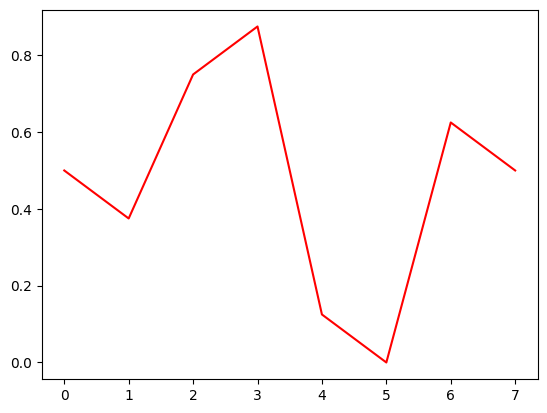

In [48]:
test_signal_1 = (np.array([0., -0.25, 0.5, 0.75, -0.75, -1, 0.25, 0.])+1)/2
# test_signal_1 = (np.array([0., -0.1, 0.2, 0.3, -0.3, -0.4, 0.3, 0.])+1)/2
# test_signal_1 = np.array([1.]*8)
# test_signal_2 = np.array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0])
test_signal_2 = np.linspace(0,1,8)
# test_signal_2 = np.array([0.01]*8)
# test_signal_2 /= np.linalg.norm(test_signal_2)
# test_signal_2 = np.exp(-np.linspace(-1,1,8)**2)
# test_signal_2 /= np.linalg.norm(test_signal_2)
plt.plot(test_signal_1, color='red')
plt.show()

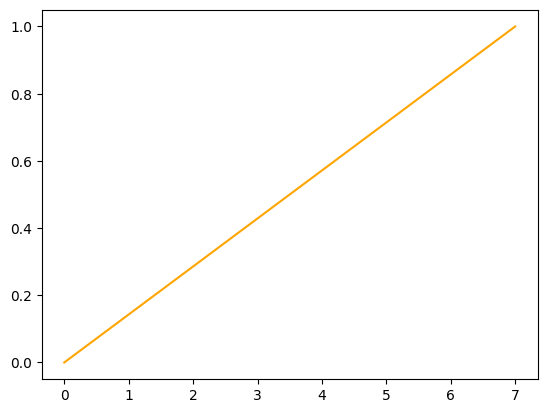

In [49]:
plt.plot(test_signal_2, color='orange')
plt.show()

In [6]:
circuit1,p1 = sqpam1.encode(test_signal_1, measure=False)
circuit2,p2 = sqpam1.encode(test_signal_2, measure=False)

Number of qubits required: 4

3 qubits for time
1 qubits for amplitude
[False, False, True, True, False, False, True, False]
Number of qubits required: 4

3 qubits for time
1 qubits for amplitude
[False, False, False, False, False, False, False, False]


In [7]:
circuit1

In [8]:
# circuit1.decompose().decompose().draw('mpl')

In [9]:
# circuit2.draw('mpl')

In [10]:
qpte = qa.utils.prepare_qpte_circuit_phase(circuit1, circuit2)

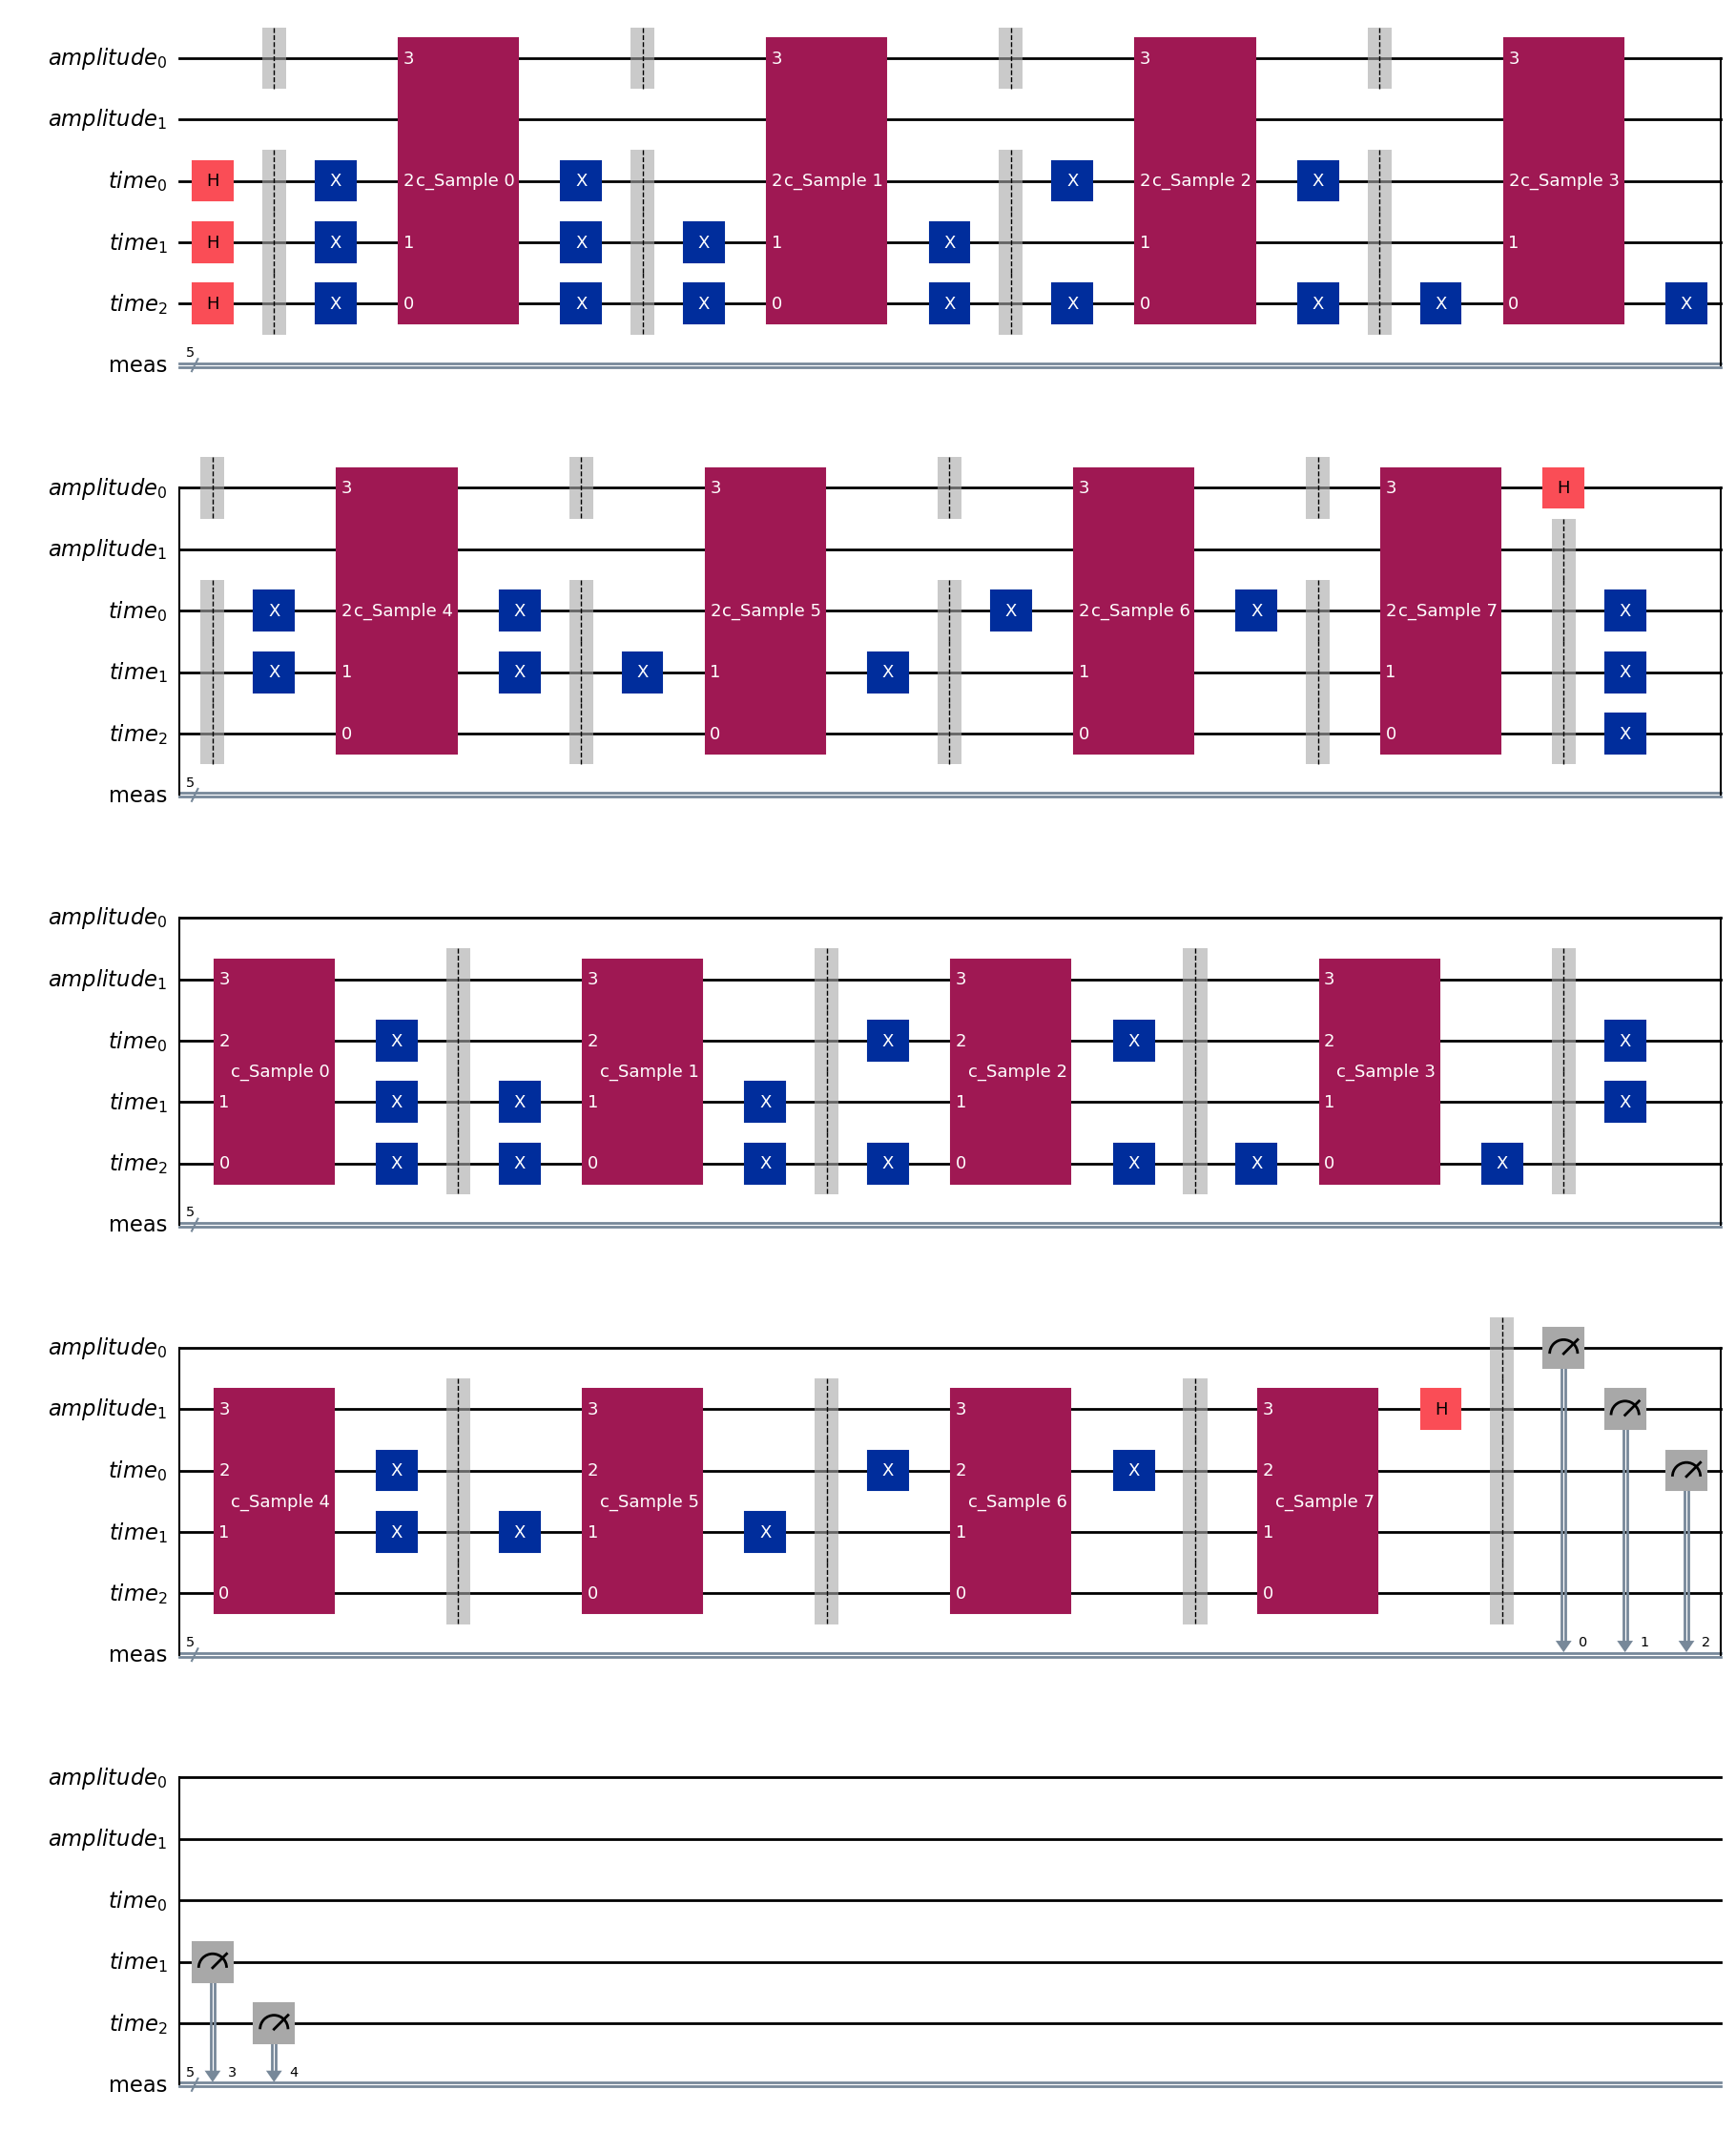

In [11]:
qpte.draw('mpl')

In [13]:
for i in range(qpte.metadata['qubit_shape'][1]):
    print(qpte.metadata['qubit_shape'][0]+ i)
    # qpte.h(i)

3
4


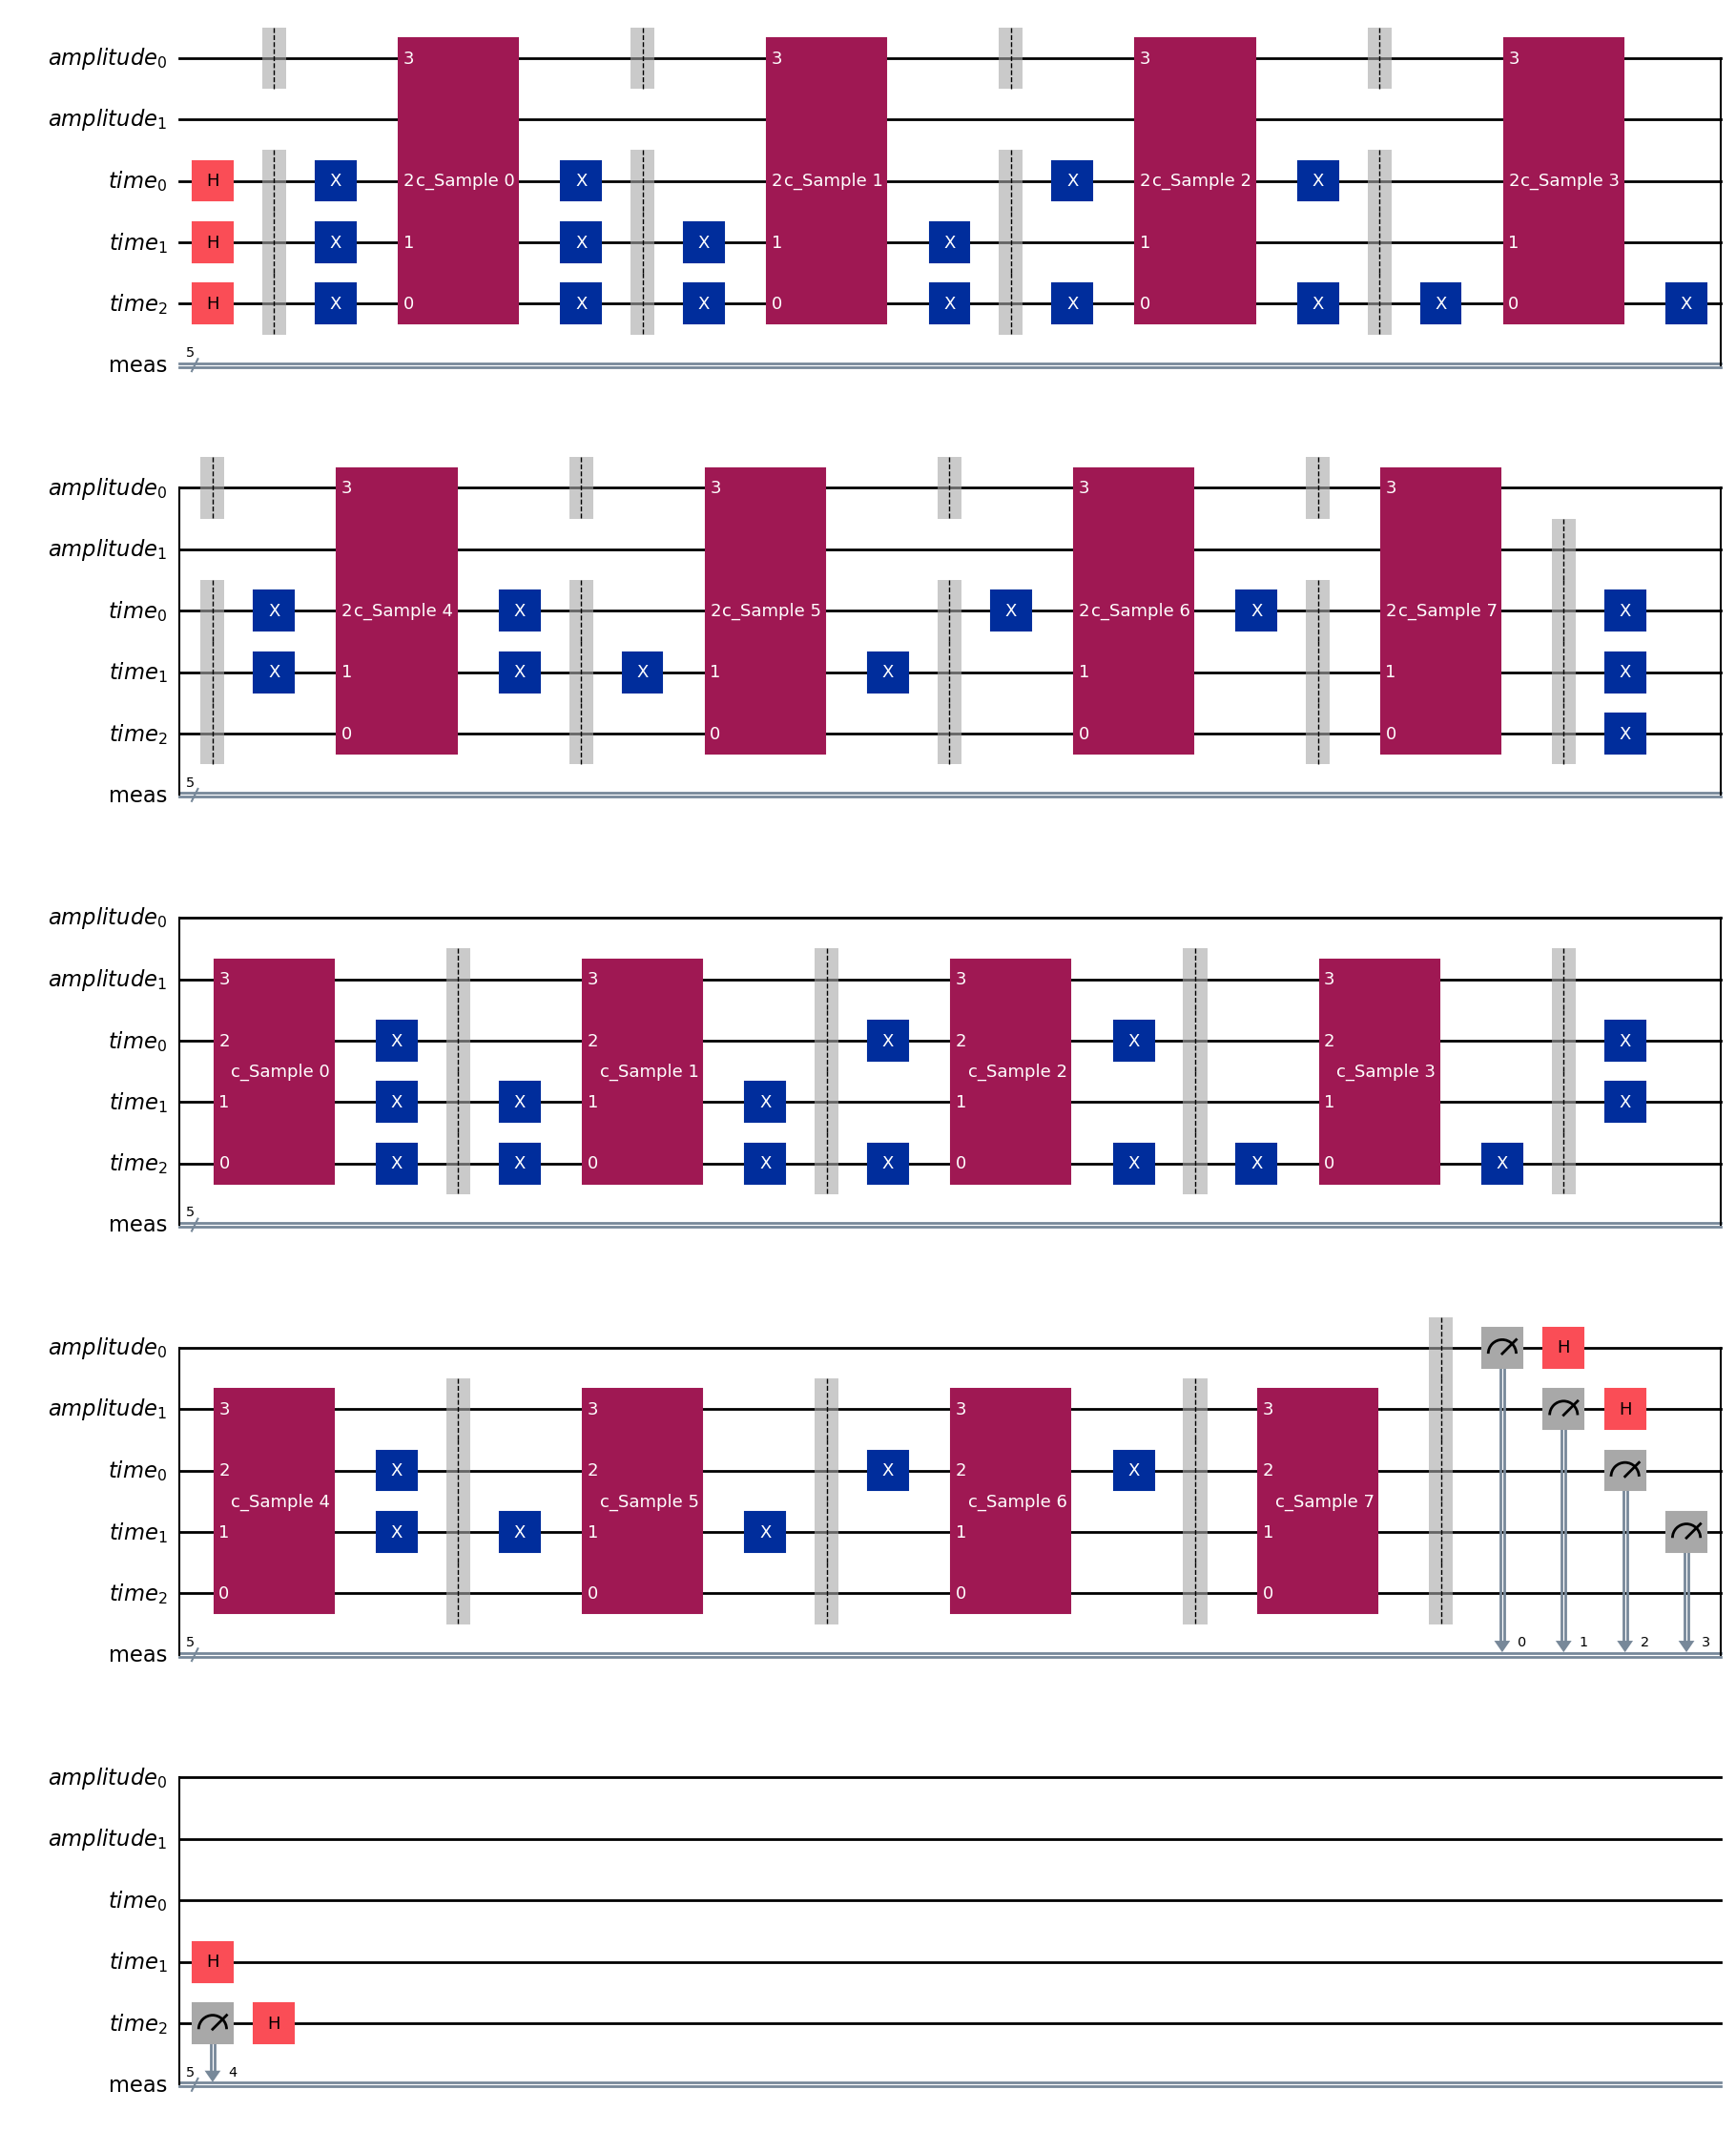

In [46]:
qpte.draw('mpl')

In [12]:
sig,result = sqpam1.decode_all_terms(qpte, n_of_terms= 4, return_result=True, shots=1000000)
sig

[array([0.24921991, 0.79294453, 0.        , 0.06702109, 0.9288319 ,
        0.47417134, 0.05612367, 0.2507357 ]),
 array([0.2502091 , 0.05698466, 0.95088288, 0.92818143, 0.0662927 ,
        0.47705364, 0.79389946, 0.25079214]),
 array([0.25163257, 0.14048535, 0.        , 0.00026342, 0.00454027,
        0.02454764, 0.0100745 , 0.24921189]),
 array([0.24893843, 0.00958546, 0.04911712, 0.00453406, 0.00033513,
        0.02422738, 0.13990237, 0.24926027])]

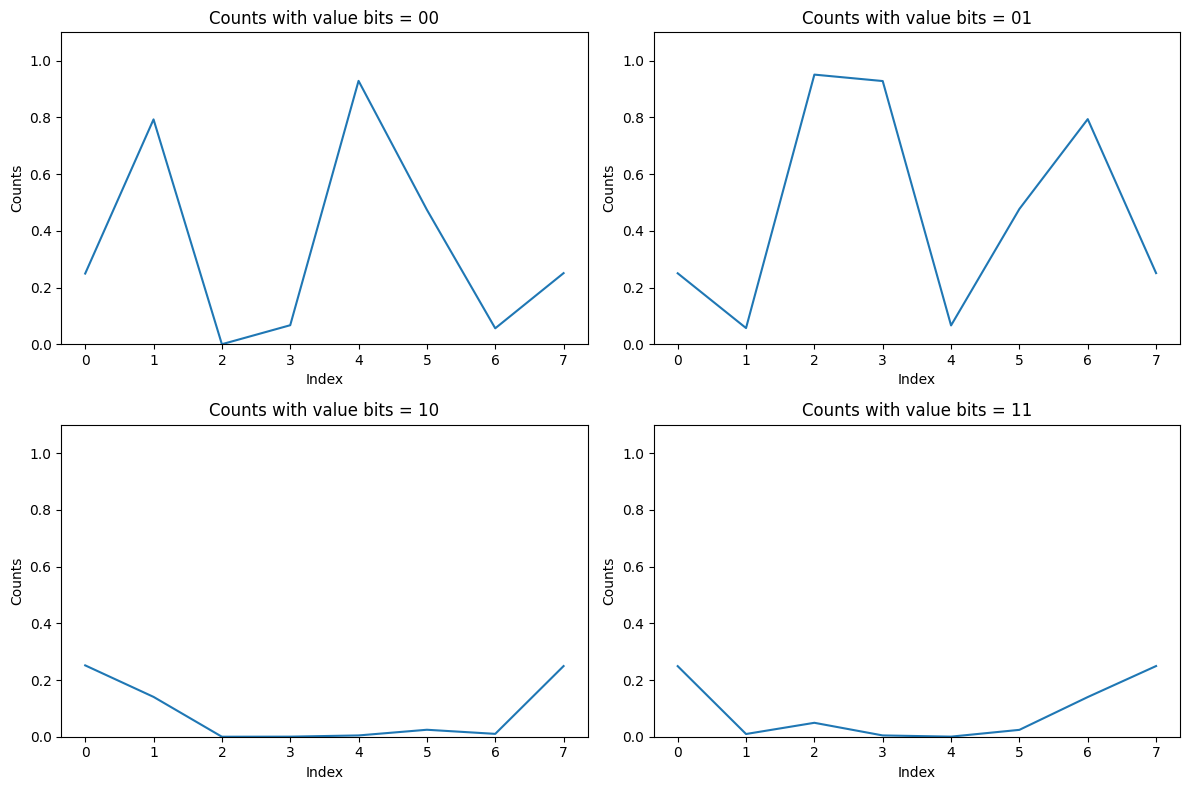

In [13]:


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
num_components=qpte.metadata['num_samples']
# Plot for bits == '00'
axs[0, 0].plot(range(num_components), sig[0])
axs[0, 0].set_title("Counts with value bits = 00")
axs[0, 0].set_xlabel("Index")
axs[0, 0].set_ylabel("Counts")

# Plot for bits == '01'
axs[0, 1].plot(range(num_components), sig[1])
axs[0, 1].set_title("Counts with value bits = 01")
axs[0, 1].set_xlabel("Index")
axs[0, 1].set_ylabel("Counts")

# Plot for bits == '10'
axs[1, 0].plot(range(num_components), sig[2])
axs[1, 0].set_title("Counts with value bits = 10")
axs[1, 0].set_xlabel("Index")
axs[1, 0].set_ylabel("Counts")

# Plot for bits == '11'
axs[1, 1].plot(range(num_components), sig[3])
axs[1, 1].set_title("Counts with value bits = 11")
axs[1, 1].set_xlabel("Index")
axs[1, 1].set_ylabel("Counts")

# Set the same y-range for all subplots
# max_count_value = max(counts.values())
for row in axs:
    for ax in row:
        ax.set_ylim([0,  1.1])

plt.tight_layout()
plt.show()

In [52]:
def run_qpte_and_compare(input1, input2, shots=1000000):
    sqpam = qa.load_scheme('sqpam_qpte')
    

    circuit1, p1 = sqpam.encode(input1, measure=False, verbose=False)
    circuit2, p2 = sqpam.encode(input2, measure=False, verbose=False)

    cp1 = circuit1.copy()
    cp2 = circuit2.copy()

    qpte = qa.utils.prepare_qpte_circuit(circuit1, circuit2)
    qpte_phase = qa.utils.prepare_qpte_circuit_phase(cp1, cp2)

    

    sig, result = sqpam.decode_all_terms(qpte, n_of_terms= 4, return_result=True, shots=shots)
    sig_phase, result = sqpam.decode_all_terms(qpte_phase, n_of_terms= 4, return_result=True, shots=shots)
    # sig_phase = sqpam.decode(qpte_phase, which= 0, shots=shots)
    p1 = np.array(p1)*1
    p2 = np.array(p2)*1
    # sig[0] *= 1-2*p1
    # sig[0] *= 1-2*p2

    classical = input1*input2

    #Fidelity of QPTE for point-wise multiplication:
    sig_norm = sig[0]/np.sum(sig[0])
    classical_norm = classical/np.sum(classical)
    fidelity = (np.sum(np.sqrt(sig_norm*classical_norm)))**2

    rmsd =  np.sqrt(np.mean((sig_norm - classical_norm)**2))

    num_components=qpte.metadata['num_samples']
    
    # fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    # # Plot for bits == '00'
    # axs[0, 0].plot(range(num_components), sig[0])
    # axs[0, 0].set_title("Counts with value bits = 00")
    # axs[0, 0].set_xlabel("Index")
    # axs[0, 0].set_ylabel("Counts")
    
    # # Plot for bits == '01'
    # axs[0, 1].plot(range(num_components), sig[1])
    # axs[0, 1].set_title("Counts with value bits = 01")
    # axs[0, 1].set_xlabel("Index")
    # axs[0, 1].set_ylabel("Counts")
    
    # # Plot for bits == '10'
    # axs[1, 0].plot(range(num_components), sig[2])
    # axs[1, 0].set_title("Counts with value bits = 10")
    # axs[1, 0].set_xlabel("Index")
    # axs[1, 0].set_ylabel("Counts")
    
    # # Plot for bits == '11'
    # axs[1, 1].plot(range(num_components), sig[3])
    # axs[1, 1].set_title("Counts with value bits = 11")
    # axs[1, 1].set_xlabel("Index")
    # axs[1, 1].set_ylabel("Counts")
    
    # # Set the same y-range for all subplots
    # # max_count_value = max(counts.values())
    # # for row in axs:
    # #     for ax in row:
    # #         ax.set_ylim([0,  1.1])
    
    # plt.tight_layout()
    # plt.show()


    # fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    # # Plot for bits == '00'
    # axs[0, 0].plot(range(num_components), sig_phase[0])
    # axs[0, 0].set_title("Counts with value bits = 00")
    # axs[0, 0].set_xlabel("Index")
    # axs[0, 0].set_ylabel("Counts")
    
    # # Plot for bits == '01'
    # axs[0, 1].plot(range(num_components), sig_phase[1])
    # axs[0, 1].set_title("Counts with value bits = 01")
    # axs[0, 1].set_xlabel("Index")
    # axs[0, 1].set_ylabel("Counts")
    
    # # Plot for bits == '10'
    # axs[1, 0].plot(range(num_components), sig_phase[2])
    # axs[1, 0].set_title("Counts with value bits = 10")
    # axs[1, 0].set_xlabel("Index")
    # axs[1, 0].set_ylabel("Counts")
    
    # # Plot for bits == '11'
    # axs[1, 1].plot(range(num_components), sig_phase[3])
    # axs[1, 1].set_title("Counts with value bits = 11")
    # axs[1, 1].set_xlabel("Index")
    # axs[1, 1].set_ylabel("Counts")
    
    # # Set the same y-range for all subplots
    # # max_count_value = max(counts.values())
    # for row in axs:
    #     for ax in row:
    #         ax.set_ylim([0,  1.1])
    
    # plt.tight_layout()
    # plt.show()

    # sig_r =[]
    # for i,s in enumerate(sig):        
    #     sig_r.append(s)

    # fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    # # Plot for bits == '00'
    # axs[0, 0].plot(range(num_components), sig_r[0])
    # axs[0, 0].set_title("Counts with value bits = 00")
    # axs[0, 0].set_xlabel("Index")
    # axs[0, 0].set_ylabel("Counts")
    
    # # Plot for bits == '01'
    # axs[0, 1].plot(range(num_components), sig_r[1])
    # axs[0, 1].set_title("Counts with value bits = 01")
    # axs[0, 1].set_xlabel("Index")
    # axs[0, 1].set_ylabel("Counts")
    
    # # Plot for bits == '10'
    # axs[1, 0].plot(range(num_components), sig_r[2])
    # axs[1, 0].set_title("Counts with value bits = 10")
    # axs[1, 0].set_xlabel("Index")
    # axs[1, 0].set_ylabel("Counts")
    
    # # Plot for bits == '11'
    # axs[1, 1].plot(range(num_components), sig_r[3])
    # axs[1, 1].set_title("Counts with value bits = 11")
    # axs[1, 1].set_xlabel("Index")
    # axs[1, 1].set_ylabel("Counts")
    
    # # Set the same y-range for all subplots
    # # max_count_value = max(counts.values())
    # # for row in axs:
    # #     for ax in row:
    # #         ax.set_ylim([0,  1.1])
    
    # plt.tight_layout()
    # plt.show()

    fig = plt.figure(figsize=(14, 8))
    gs  = fig.add_gridspec(2, 2) 
    title_fontsize = 23
    label_fontsize = 14
    tick_fontsize = 12

    # Plot for bits == '00'
    ax00 = fig.add_subplot(gs[0, 0])
    ax00.plot(input1, color='darkcyan', linewidth=2)
    ax00.set_title("Input 1", fontsize=title_fontsize)
    ax00.set_xlabel("Index", fontsize=label_fontsize)
    ax00.set_ylabel("Amplitude", fontsize=label_fontsize)
    ax00.tick_params(labelsize=tick_fontsize)
    
    # Plot for bits == '01'
    ax01 = fig.add_subplot(gs[0, 1])
    ax01.plot(input2, color='indigo', linewidth=2)
    ax01.set_title("Input 2", fontsize=title_fontsize)
    ax01.set_xlabel("Index", fontsize=label_fontsize)
    ax01.set_ylabel("Counts", fontsize=label_fontsize)
    ax01.tick_params(labelsize=tick_fontsize)
    
    # Combined plot
    ax10 = fig.add_subplot(gs[1, :])
    ax10.plot(classical, label="Classical Multiplication ", color='red', linewidth=3)
    ax10.plot(sig[0], '.-', label="QPTE Result", color='midnightblue', markersize=15)
    ax10.set_title(f"QPTE Output Sample (Fidelity: {fidelity*100:.5f}%, RMSD: {rmsd*100:.2f}%, shots:{shots:.0e})", fontsize=title_fontsize)
    ax10.set_xlabel("Index", fontsize=label_fontsize)
    ax10.set_ylabel("Counts", fontsize=label_fontsize)
    ax10.tick_params(labelsize=tick_fontsize)
    ax10.legend(fontsize=label_fontsize)

    
    # Set the same y-range for all subplots
    # max_count_value = max(counts.values())
    for row in axs:
        for ax in row:
            ax.set_ylim([0,  1.1])
    
    plt.tight_layout()
    plt.show()


    return sig, classical, rmsd, fidelity, p1, p2, sig_phase
    
    

Single-Qubit Probability Amplitude Modulation Variant for QPTE algorithm
[False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False]


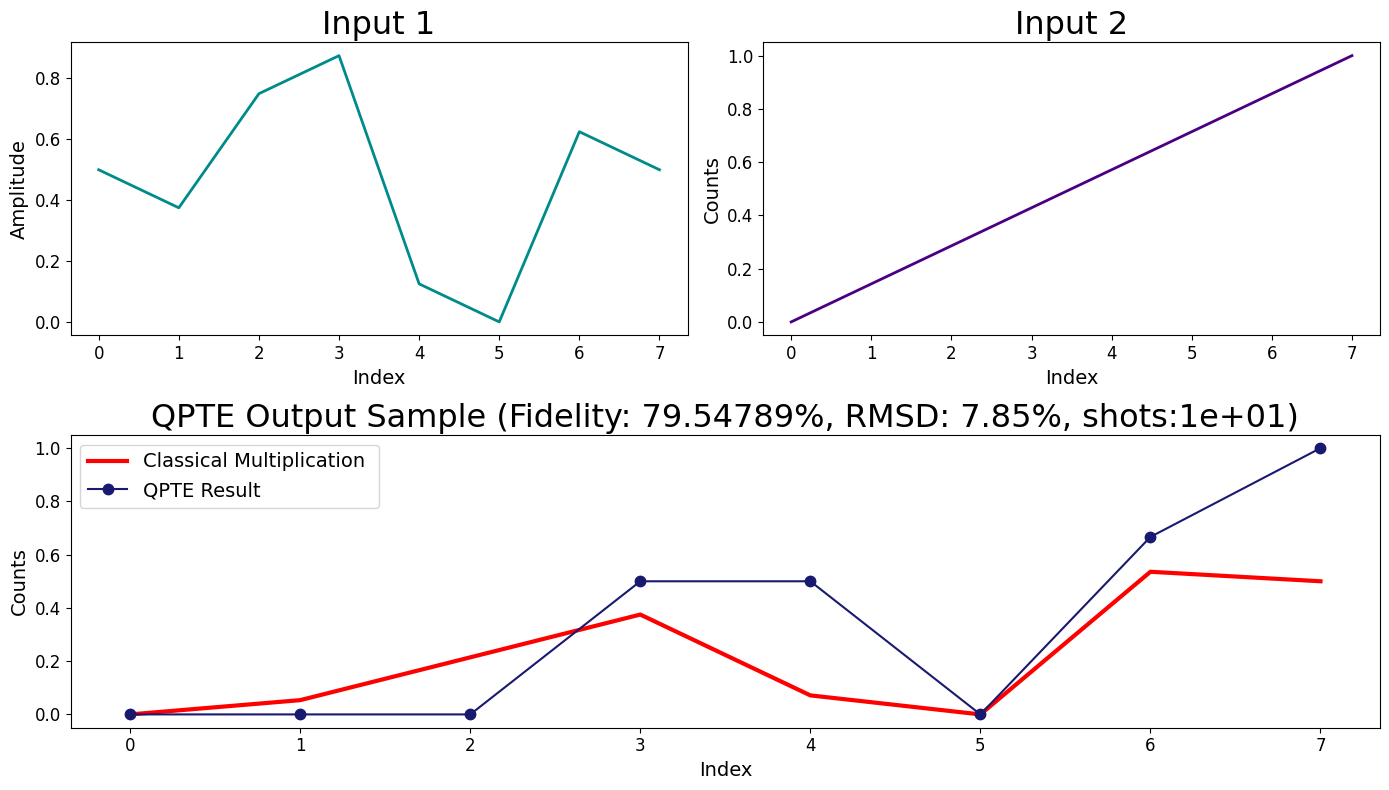

Single-Qubit Probability Amplitude Modulation Variant for QPTE algorithm
[False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False]


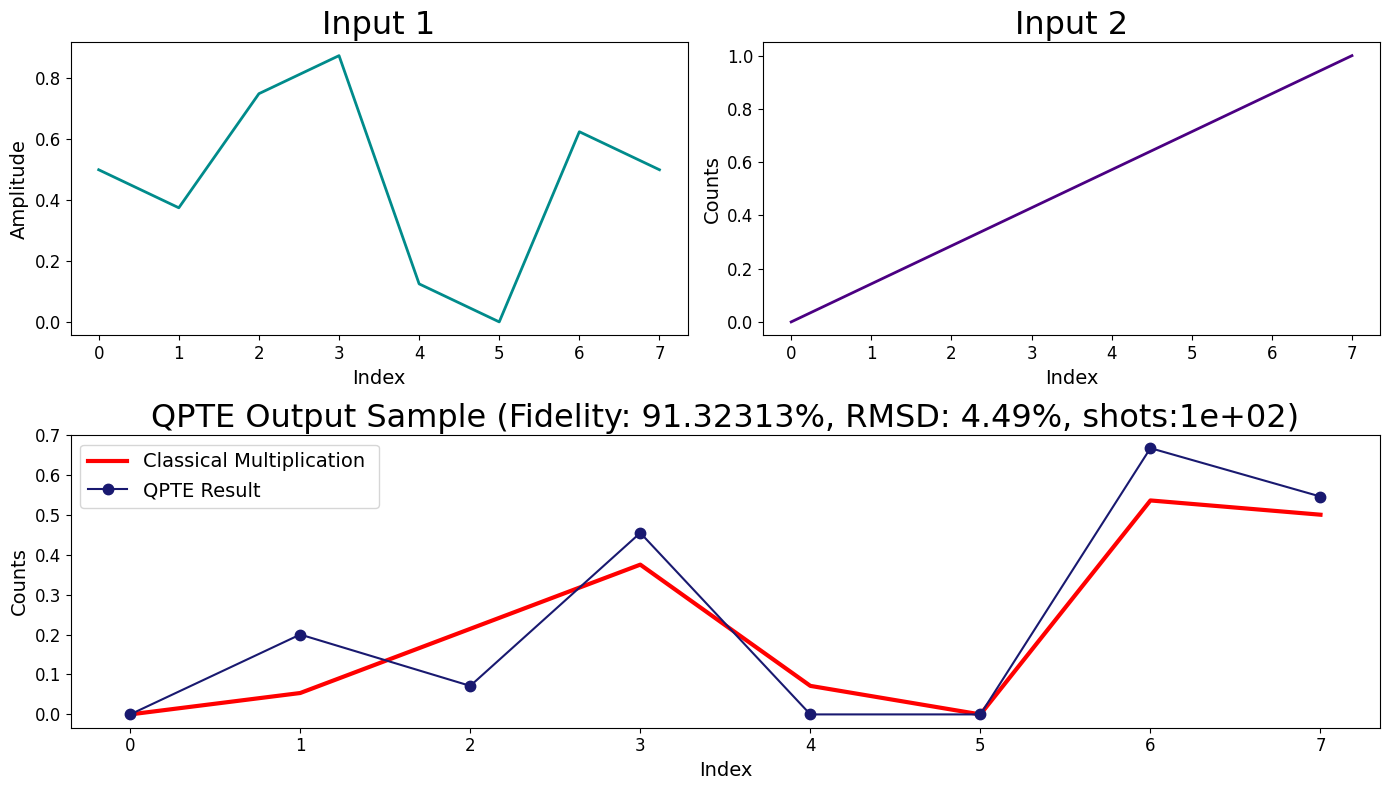

Single-Qubit Probability Amplitude Modulation Variant for QPTE algorithm
[False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False]


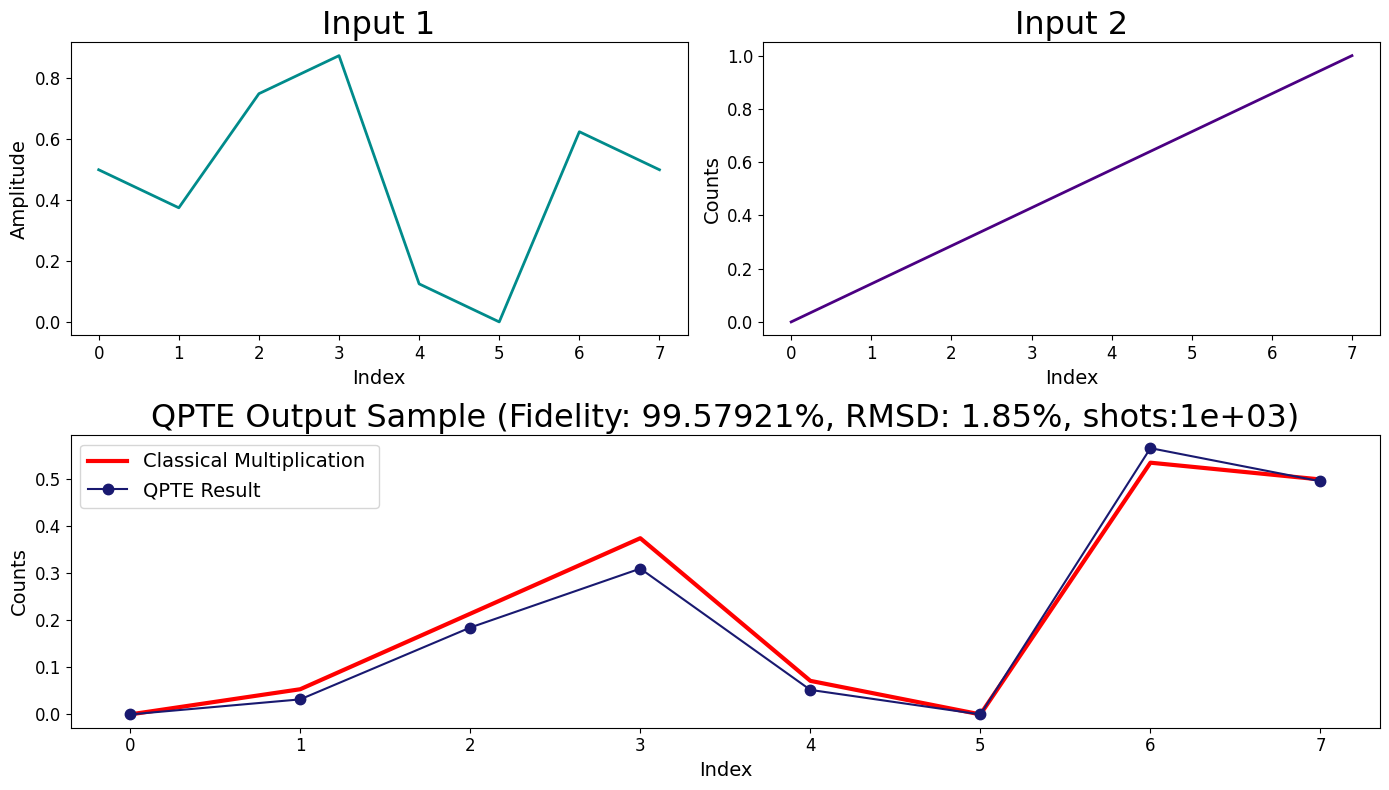

Single-Qubit Probability Amplitude Modulation Variant for QPTE algorithm
[False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False]


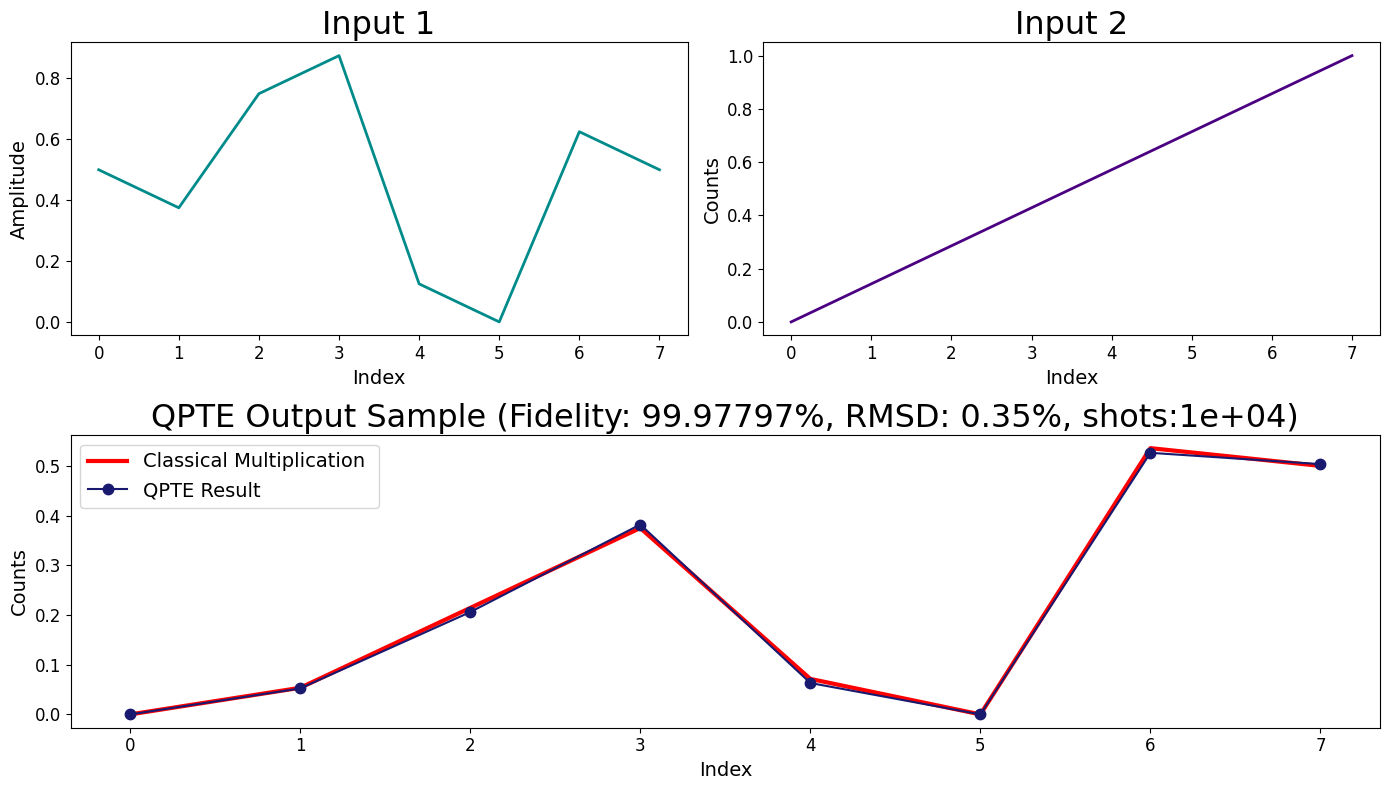

Single-Qubit Probability Amplitude Modulation Variant for QPTE algorithm
[False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False]


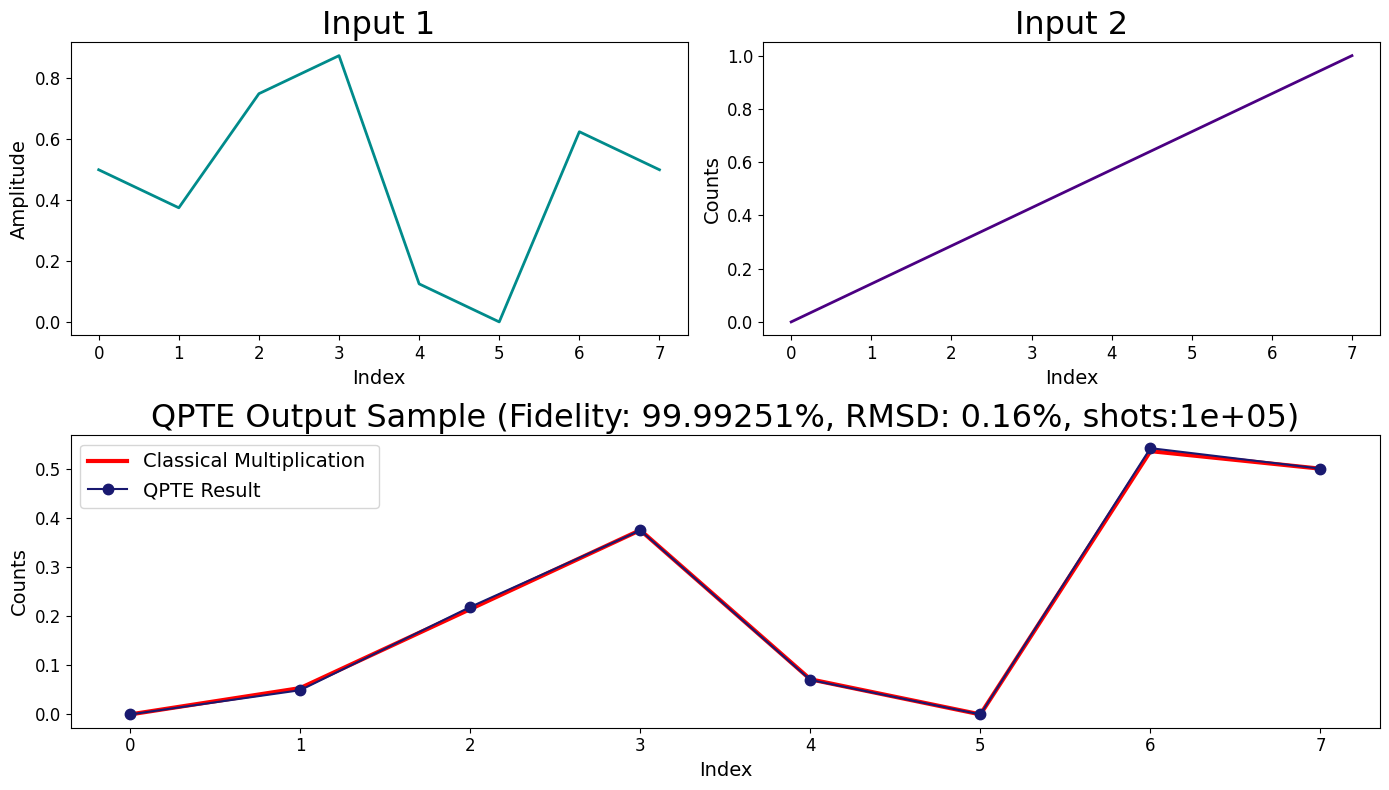

Single-Qubit Probability Amplitude Modulation Variant for QPTE algorithm
[False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False]


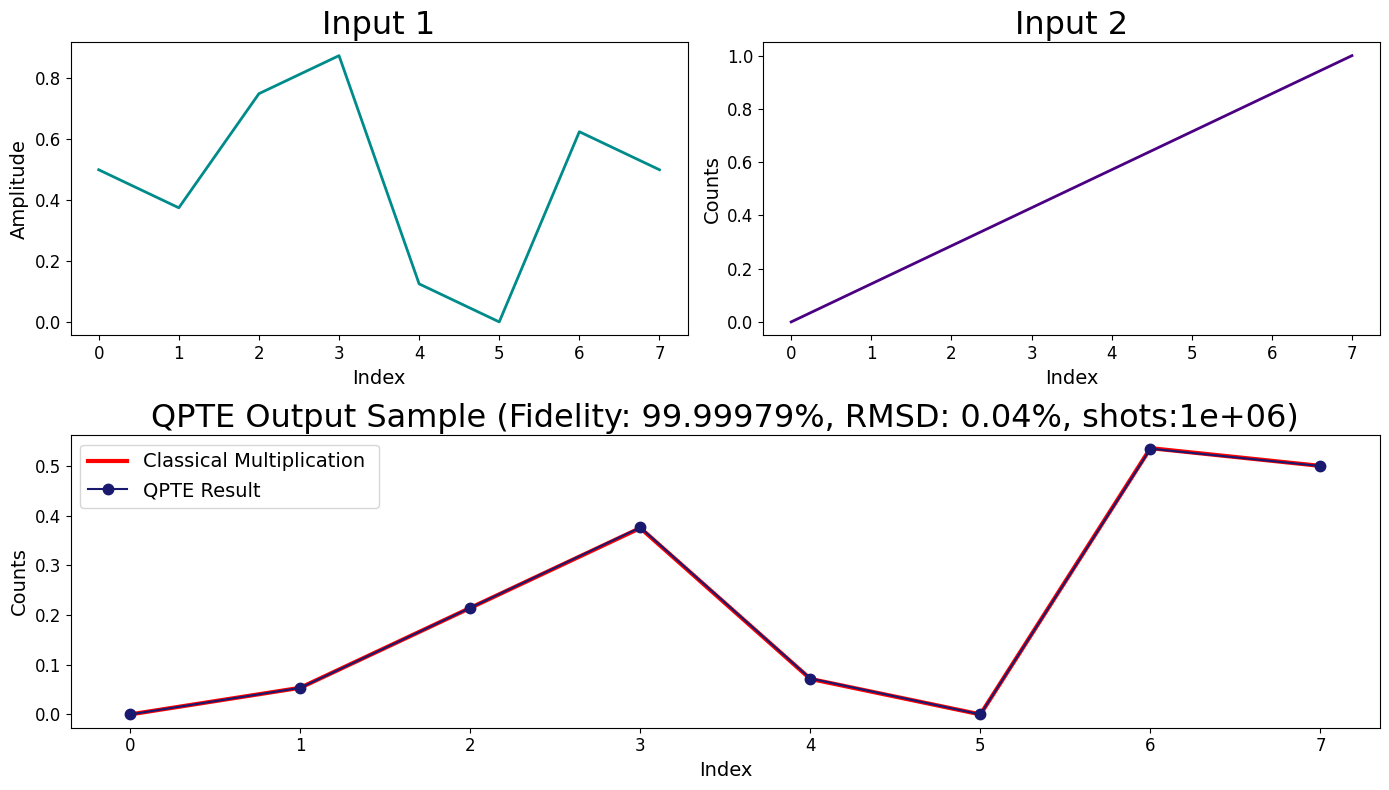

Single-Qubit Probability Amplitude Modulation Variant for QPTE algorithm
[False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False]


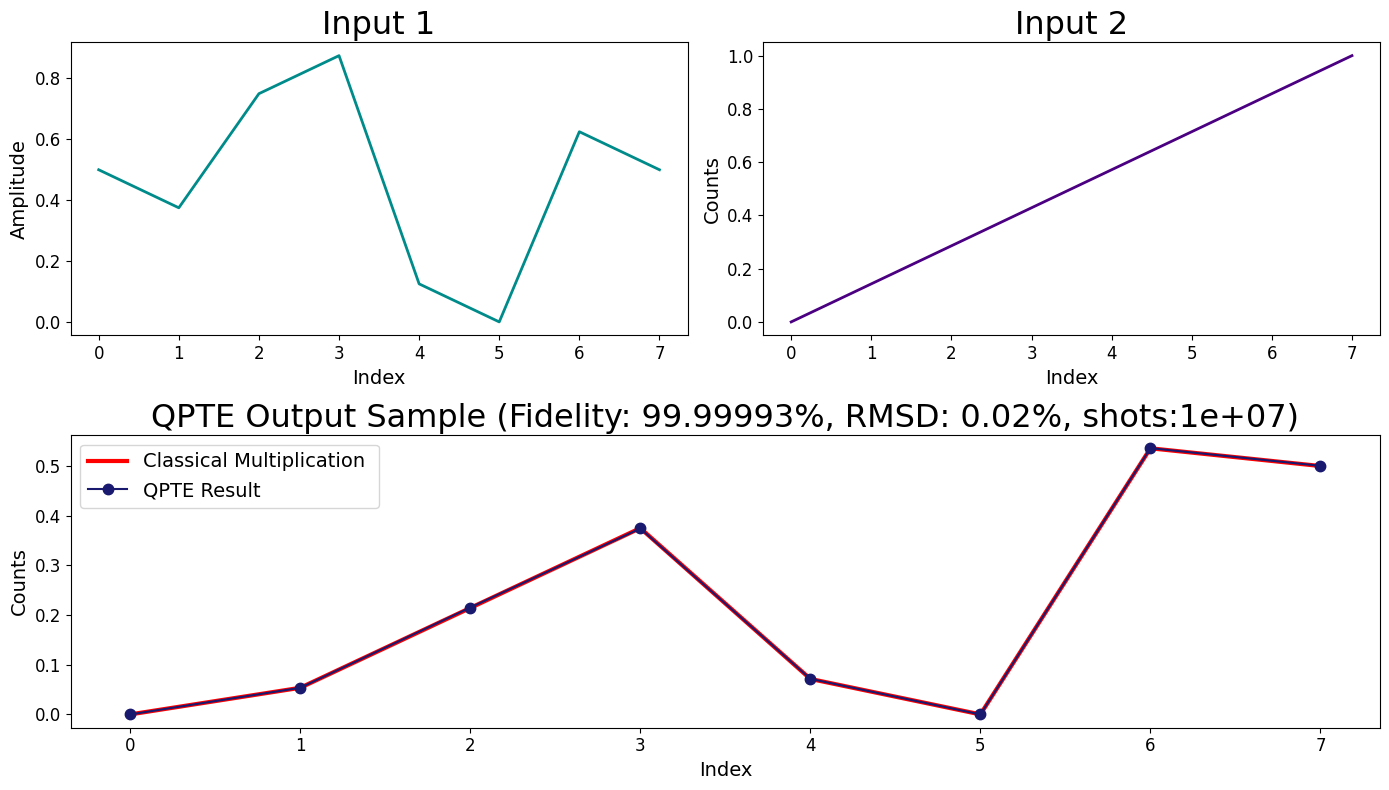

In [53]:
rs= []
fs= []
shotss = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
for shots in shotss:
    s, c, r, f, p1, p2, sp = run_qpte_and_compare(test_signal_1, test_signal_2, shots=shots)
    rs.append(r)
    fs.append(f)
# print('Shots |  RMSD  |  Fidelity  |')



In [16]:
print('|  Shots  | RMSD (%) | Fidelity (%) |')
for i, sh in enumerate(shotss):
    print(f'|  {sh:.0e}  | {100*rs[i]:6.2f}   |   {100*fs[i]:2.5f}   |') 

|  Shots  | RMSD (%) | Fidelity (%) |
|  1e+07  |   0.01   |   99.99997   |


In [21]:
sp[0]>0.5

array([False,  True, False, False,  True, False, False, False])

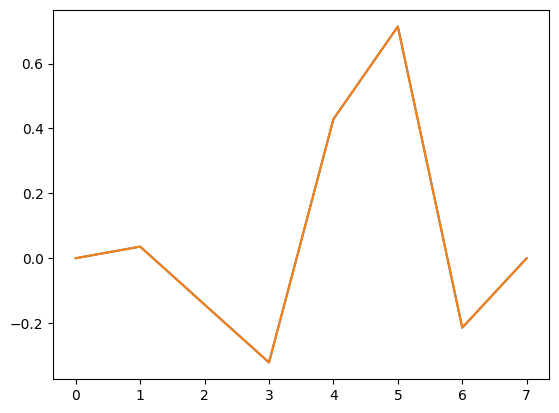

In [41]:
p1 = np.array(p1)*1
plt.plot(test_signal_1*test_signal_2)
# plt.plot(s)
plt.plot(s*(1-2*p1))

In [125]:
fidelity = (np.sum(np.sqrt((s/np.sum(s))*(c/np.sum(c)))))**2
fidelity

np.float64(0.9999979122595736)

In [36]:
result = qa.utils.execute(qpte, shots=1000000)
counts = result.get_counts()

In [37]:
sig = sqpam1.decode_result(result, which=3)

In [17]:
qpte.metadata['qubit_shape']

(3, 2)

In [41]:
def decode_components(
        counts: Union[dict, qiskit.result.Counts],
        qubit_shape: [int, int],
    ) -> np.ndarray:
        """The first stage of decoding is extracting required components from
        counts.

        Args:
            counts: a dictionary with the outcome of measurements
                    performed on the quantum circuit.
            qubit_shape: Tuple to determine the number of cosine and sine components to get.

        Returns:
            Array of components for further decoding.
        """
        # initialising components
        num_index_qubits = qubit_shape[0]
        num_components = 2**num_index_qubits
        counts_00 = np.zeros(num_components)
        counts_01 = np.zeros(num_components)
        counts_10 = np.zeros(num_components)
        counts_11 = np.zeros(num_components)

        # getting components from counts
        for state in counts:
            index_bits, value_bits = qa.utils.split_string(state, qubit_shape)
            
            
            index = int(index_bits, 2)
            value = counts[state]
            if value_bits == "00":
                counts_00[index] = value
            elif value_bits == "01":
                counts_01[index] = value
            elif value_bits == "10":
                counts_10[index] = value
            elif value_bits == "11":
                counts_11[index] = value

        return counts_00, counts_01, counts_10, counts_11

In [29]:
sqpam1.decode(qpte, inverted=1)

array([-1., -1., -1., -1., -1., -1., -1., -1.])

In [16]:
counts = result.get_counts()



In [17]:
counts_00, counts_01, counts_10, counts_11 = sqpam1.decode_components(counts, (3,2))

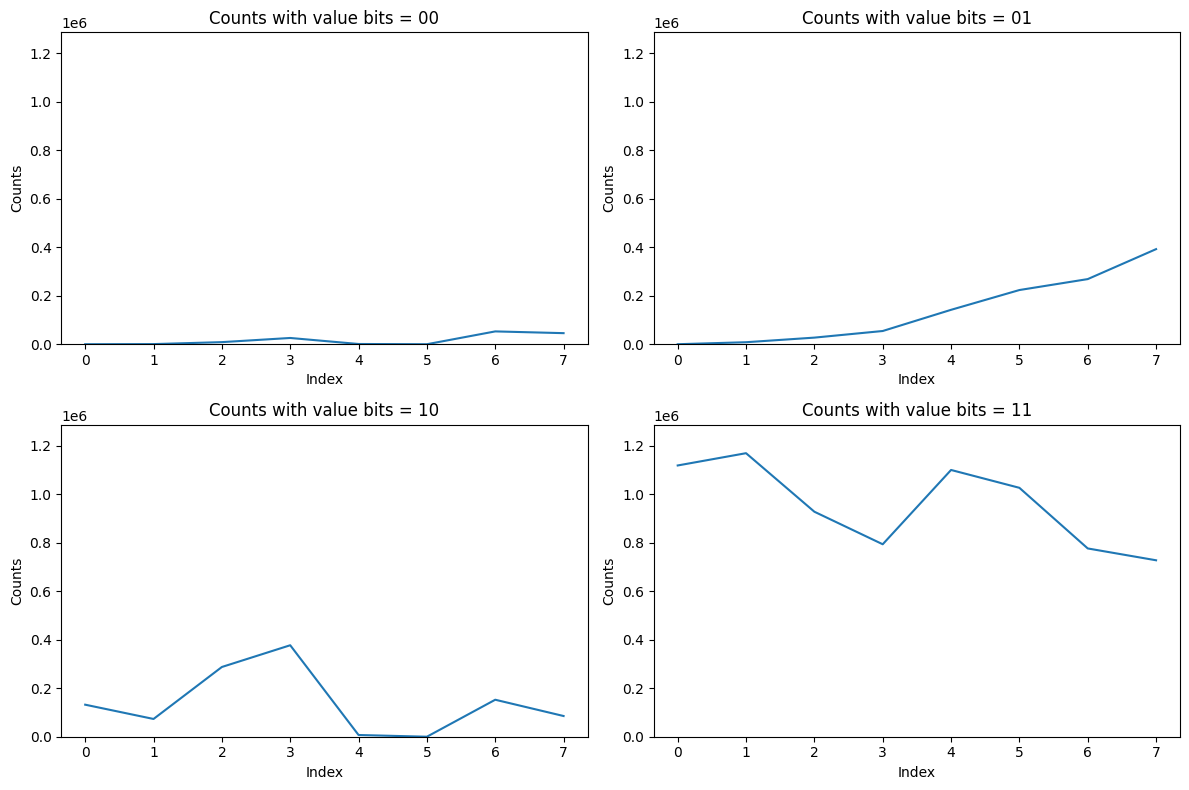

In [20]:
# counts_00, counts_01, counts_10, counts_11 = sqpam1.decode_components(counts, (3,2))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
num_components=8
# Plot for bits == '00'
axs[0, 0].plot(range(num_components), counts_00)
axs[0, 0].set_title("Counts with value bits = 00")
axs[0, 0].set_xlabel("Index")
axs[0, 0].set_ylabel("Counts")

# Plot for bits == '01'
axs[0, 1].plot(range(num_components), counts_01)
axs[0, 1].set_title("Counts with value bits = 01")
axs[0, 1].set_xlabel("Index")
axs[0, 1].set_ylabel("Counts")

# Plot for bits == '10'
axs[1, 0].plot(range(num_components), counts_10)
axs[1, 0].set_title("Counts with value bits = 10")
axs[1, 0].set_xlabel("Index")
axs[1, 0].set_ylabel("Counts")

# Plot for bits == '11'
axs[1, 1].plot(range(num_components), counts_11)
axs[1, 1].set_title("Counts with value bits = 11")
axs[1, 1].set_xlabel("Index")
axs[1, 1].set_ylabel("Counts")

# Set the same y-range for all subplots
max_count_value = max(counts.values())
for row in axs:
    for ax in row:
        ax.set_ylim([0, max_count_value * 1.1])

plt.tight_layout()
plt.show()

In [19]:
plot_histogram(counts_00)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [22]:
def convert_from_angles(
    amps_00: np.ndarray, amps_01: np.ndarray, amps_10: np.ndarray, amps_11: np.ndarray, which: int = 0
) -> np.ndarray:

    total_amps = amps_00 + amps_01 + amps_10 + amps_11
    all_amps = [amps_00, amps_01, amps_10, amps_11]
    amps = all_amps[which]
    ratio = np.divide(
        amps, total_amps, out=np.zeros_like(amps), where=total_amps != 0
    )
    data = np.sqrt(ratio)
    return data

In [32]:
def reconstruct_data(
    self,
    counts: Union[dict, qiskit.result.Counts],
    qubit_shape: [int, int],
    which: int = 0,
) -> np.ndarray:
    """Given counts, Extract components and restore the conversion did at
    encoding stage.

    Args:
        counts: a dictionary with the outcome of measurements
                performed on the quantum circuit.
        qubit_shape: Tuple to determine the number of cosine and sine components to get.
        inverted : retrieves cosine components of the signal.

    Return:
        Array of restored values
    """
    cc_amps, cs_amps, sc_amps, ss_amps = self.decode_components(counts, qubit_shape)
    data = self.restore(cosine_amps, sine_amps, inverted)
    return data

In [34]:
def decode_counts(
        self,
        counts: Union[dict, qiskit.result.Counts],
        metadata: dict,
        which: int = 0,
        keep_padding: bool = False,
    ) -> np.ndarray:
        """Given a Qiskit counts object or Dictionary, Extract components and restore the
        conversion did at encoding stage.

        Args:
                counts: a qiskit Counts object or Dictionary obtained from a job result.
                metadata: metadata required for decoding.
                inverted: retrieves cosine components of the signal.
                keep_padding: Undo the padding set at Encoding stage if set False.

        Return:
                Array of restored values with original dimensions
        """
        # decoding x-axis
        index_position, _ = self.positions
        qubit_shape = metadata["qubit_shape"]

        original_num_samples = metadata["num_samples"]

        # decoding y-axis
        data = self.reconstruct_data(
            counts=counts, qubit_shape=qubit_shape, which=which
        )

        # undo padding
        if not keep_padding:
            data = data[:original_num_samples]

        return data

In [ ]:
def decode_result(
        self,
        result: qiskit.result.Result,
        metadata: Optional[dict] = None,
        inverted: bool = False,
        keep_padding: bool = False,
    ) -> np.ndarray:
        """Given a result object. Extract components and restore the conversion
        did in encoding stage.

        Args:
                result: a qiskit Result object that contains counts along
                        with metadata that was held by the original circuit.
                metadata: optionally pass metadata as argument.
                inverted: retrieves cosine components of the signal.
                keep_padding: Undo the padding set at Encoding stage if set False.

        Return:
                Array of restored values with original dimensions
        """
        counts = utils.get_counts(result)
        metadata = utils.get_metadata(result) if not metadata else metadata

        data = self.decode_counts(
            counts=counts,
            metadata=metadata,
            inverted=inverted,
            keep_padding=keep_padding,
        )
        return data

In [26]:
outs = [None]*4
for i, out in enumerate(outs):
    outs[i] = sqpam1.reconstruct_data(counts, (3,2), which=i)

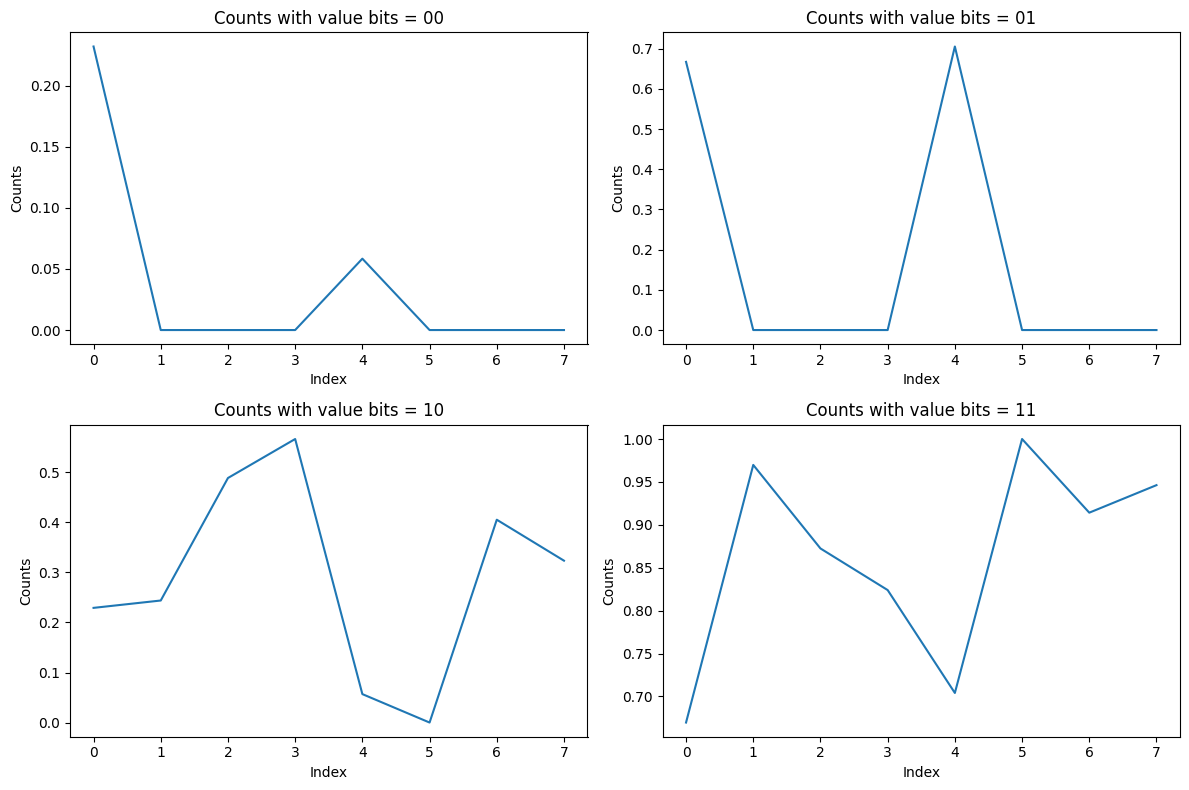

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(range(num_components), outs[0])
axs[0, 0].set_title("Counts with value bits = 00")
axs[0, 0].set_xlabel("Index")
axs[0, 0].set_ylabel("Counts")

axs[0, 1].plot(range(num_components), outs[1])
axs[0, 1].set_title("Counts with value bits = 01")
axs[0, 1].set_xlabel("Index")
axs[0, 1].set_ylabel("Counts")

axs[1, 0].plot(range(num_components), outs[2])
axs[1, 0].set_title("Counts with value bits = 10")
axs[1, 0].set_xlabel("Index")
axs[1, 0].set_ylabel("Counts")

axs[1, 1].plot(range(num_components), outs[3])
axs[1, 1].set_title("Counts with value bits = 11")
axs[1, 1].set_xlabel("Index")
axs[1, 1].set_ylabel("Counts")


# max_count_value = max(counts.values())
# for row in axs:
#     for ax in row:
#         ax.set_ylim([0, max_count_value * 1.1])

plt.tight_layout()
plt.show()

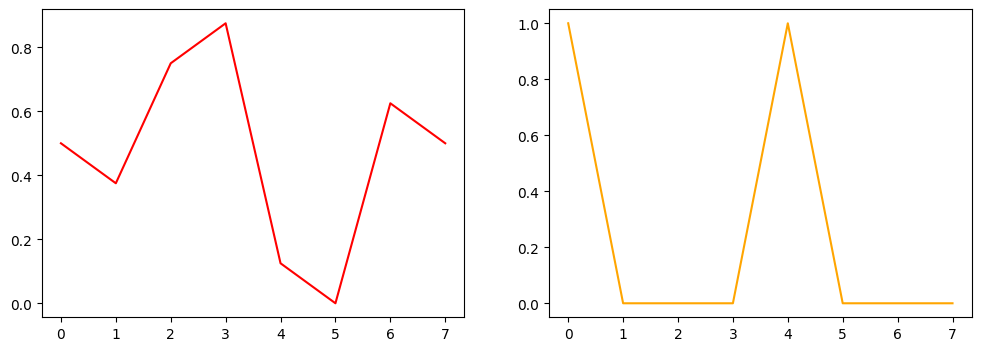

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(test_signal_1, color='red')
axs[1].plot(test_signal_2, color='orange')

ValueError: x, y, and format string must not be None

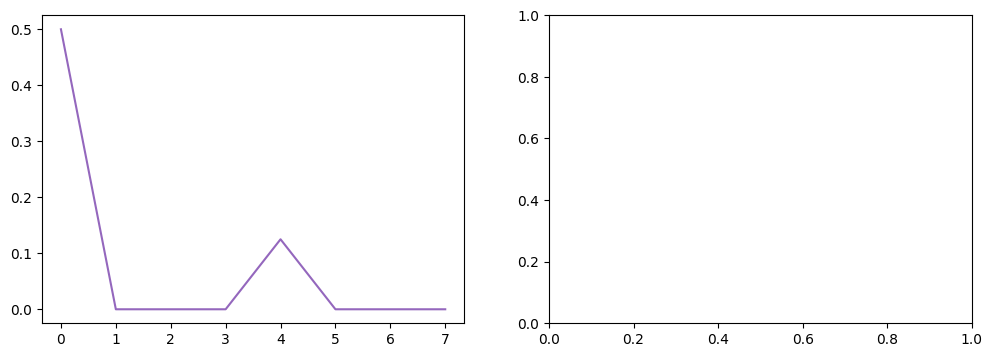

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(test_signal_1*test_signal_2, color='C4')
axs[1].plot(outs[0], color='darkblue')